In [1]:
# Raw Package
import numpy as np
import pandas as pd
import yfinance as yf
import logging
from io import BytesIO
from datetime import date, timedelta
from datetime import datetime
import time
import os
from dotenv import load_dotenv
from minio import Minio
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s: [%(levelname)s]: %(message)s"
)

def get_minio_credentials():
    """
    Returns the credentials required to connect to Minio.
    The credentials are read from environment variables using the `dotenv` library.
    """
    logging.info("Reading env variables to connect to Minio ...")
    load_dotenv()
    bucket_name = os.getenv("S3_BUCKET")
    access_key_id = os.getenv("S3_ACCESS_KEY")
    secret_access_key = os.getenv("S3_SECRET_KEY")
    minio_api_url = os.getenv("S3_URL")
    return bucket_name, access_key_id, secret_access_key, minio_api_url


def create_minio_client(minio_api_url, access_key_id, secret_access_key, bucket_name):
    """
    Creates a Minio client object and checks connection to the specified bucket.

    Args:
        minio_api_url (str): The URL of the Minio server.
        access_key_id (str): The access key ID for the Minio server.
        secret_access_key (str): The secret access key for the Minio server.
        bucket_name (str): The name of the bucket to check for connection.

    Returns:
        A `minio.Minio` object representing the Minio client.

    Raises:
        `minio.error.ResponseError` if the bucket is not reachable.
    """
    logging.info("Creating Minio Client ...")
    client = Minio(
        minio_api_url,
        access_key=access_key_id,
        secret_key=secret_access_key,
        secure=False
    )
    client.bucket_exists(bucket_name)
    logging.info("Minio object storage connected")

    return client

def parse_date():
    """
    Returns the current day, month, and year as integers.
    """
    now = datetime.now()
    day = now.day
    month = now.month
    year = now.year
    return day, month, year


def model_arch():
    model = Sequential()
    model.add(LSTM( units=50, activation='relu', return_sequences = True,
                input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM( units=60, activation='relu', return_sequences = True))
    model.add(Dropout(0.3))

    model.add(LSTM( units=80, activation='relu', return_sequences = True))
    model.add(Dropout(0.4))
            
    model.add(LSTM( units=120, activation='relu'))
    model.add(Dropout(0.5))
            
    model.add(Dense(units = 1))
    return model

def model_forecast(model, X, window_size):
    """Takes in numpy array, creates a windowed tensor 
    and predicts the following value on each window"""
    data = tf.data.Dataset.from_tensor_slices(X)
    data = data.window(window_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window_size))
    data = data.batch(32).prefetch(1)
    forecast = model.predict(data)
    return forecast

def df_from_bucket(minio_client, bucket, path):
    obj = minio_client.get_object(
        bucket,
        path,
    )
    out_df = pd.read_csv(obj, lineterminator='\n')
    return out_df


2023-04-23 12:37:07.220179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
load_dotenv()
start_time = time.time()
bucket_name, access_key_id, secret_access_key, minio_api_url = get_minio_credentials()
minio_client = create_minio_client('localhost:9002', access_key_id, secret_access_key, bucket_name)

2023-04-23 12:37:11,454: [INFO]: Reading env variables to connect to Minio ...
2023-04-23 12:37:11,456: [INFO]: Creating Minio Client ...
2023-04-23 12:37:11,483: [INFO]: Minio object storage connected


In [3]:
day, month, year = parse_date()
btc_path = f"bitcoin_data/{day}-{month}-{year}/bitcoin.csv"
btc_data = df_from_bucket(minio_client, bucket_name, btc_path)
eth_path = f"etherium_data/{day}-{month}-{year}/etherium.csv"
eth_data = df_from_bucket(minio_client, bucket_name, eth_path)


In [4]:

import matplotlib.pyplot as plt
train = pd.DataFrame(btc_data['Close'][0:int(len(btc_data)*0.7)])
test = pd.DataFrame(btc_data['Close'][int(len(btc_data)*0.7):int(len(btc_data))])
logging.info(f"Training data shape: {train.shape}")
logging.info(f"Validation data shape: {test.shape}")
scaler = MinMaxScaler(feature_range=(0,1))
train_array = scaler.fit_transform(train) 
x_train = []
y_train = []

for i in range(100, train_array.shape[0]):
    x_train.append(train_array[i-100:i])
    y_train.append(train_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
model = model_arch()
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=5)
model.save('keras_model.h5')


2023-04-23 12:37:12,178: [INFO]: Training data shape: (3918, 1)
2023-04-23 12:37:12,179: [INFO]: Validation data shape: (1680, 1)


Epoch 1/5
120/120 [==============================] - 22s 146ms/step - loss: 0.0458
Epoch 2/5
120/120 [==============================] - 21s 175ms/step - loss: 0.0111
Epoch 3/5
120/120 [==============================] - 20s 163ms/step - loss: 0.0093
Epoch 4/5
120/120 [==============================] - 18s 153ms/step - loss: 0.0084
Epoch 5/5
120/120 [==============================] - 18s 150ms/step - loss: 0.0077


53/53 [==============================] - 3s 48ms/step


--- Logging error ---
Traceback (most recent call last):
  File "/Users/olawaleabimbola/opt/anaconda3/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/Users/olawaleabimbola/opt/anaconda3/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/Users/olawaleabimbola/opt/anaconda3/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/Users/olawaleabimbola/opt/anaconda3/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/olawaleabimbola/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/olawaleabimbola/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/olawaleabimbola/Documents/Scheduler-for-automate

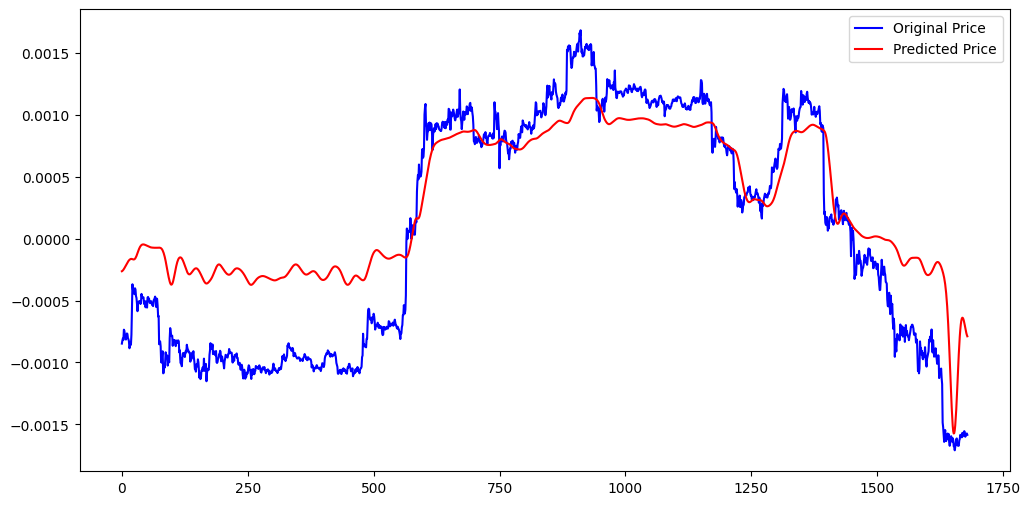

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Create StandardScaler object
scaler = StandardScaler()
past_100_days = train.tail(100)
final_df = pd.concat([past_100_days, test], ignore_index=True)
input_data = scaler.fit_transform(final_df) 

x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
y_predicted = model.predict(x_test)
scaler = scaler.scale_

scale_factor = 1/scaler
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_predicted)

logging.info("MSE: ", mse)





plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_predicted, 'r', label='Predicted Price')
plt.legend()
plt.show()

In [12]:
past_100_days

,Close
3818,28131.414062
3819,28189.726562
3820,28113.345703
3821,28127.427734
3822,28137.226562
...,...
3913,28134.619141
3914,28175.957031
3915,28097.566406
3916,28115.878906


In [10]:

import matplotlib.pyplot as plt
import seaborn as sns
train_window = [i for i in range(split_time-window_size)]

forecast = model_forecast(model,x_train,window_size)

plt.figure(figsize=(8,5),dpi=120)
sns.lineplot(train_window,forecast[:-1,1,0],label='Forecast')
sns.lineplot(train_window,X[:split_time-window_size,1],label='BTC-USD')

NameError: name 'split_time' is not defined

In [ ]:
forecast

array([[[6.617473],
        [6.617473],
        [6.617473],
        ...,
        [6.617473],
        [6.617473],
        [6.617473]],

       [[6.617473],
        [6.617473],
        [6.617473],
        ...,
        [6.617473],
        [6.617473],
        [6.617473]],

       [[6.617473],
        [6.617473],
        [6.617473],
        ...,
        [6.617473],
        [6.617473],
        [6.617473]],

       ...,

       [[6.617473],
        [6.617473],
        [6.617473],
        ...,
        [6.617473],
        [6.617473],
        [6.617473]],

       [[6.617473],
        [6.617473],
        [6.617473],
        ...,
        [6.617473],
        [6.617473],
        [6.617473]],

       [[6.617473],
        [6.617473],
        [6.617473],
        ...,
        [6.617473],
        [6.617473],
        [6.617473]]], dtype=float32)